<font size="+3"><b><u>Pneumonia and COVID Detection using Transfer Learning</u></b></font>

<a id="5"></a>
<font color="blue" size=+2.5><b>Library Import</b></font>

In [1]:
#importing libraries
import fastai
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
print(fastai.__version__)
import warnings
warnings.filterwarnings('ignore')
from fastai.metrics import error_rate, accuracy

import torch
torch.cuda.device(0)
torch.cuda.get_device_capability()
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


1.0.61
True
NVIDIA GeForce RTX 3060 Ti


<a id="6"></a>
<font color="blue" size=+2.5><b>Setting up path for training data</b></font>

In [2]:
# path  = '../Datasets/CXR_20k'
path  = '../Datasets/CXR_30k'
os.listdir(path)

['desktop.ini', 'Test', 'Train', 'Val']

<a id="7"></a>
<font color="blue" size=+2.5><b>Data Loading For training</b></font>
<br/>

In [3]:
np.random.seed(40)
data = ImageDataBunch.from_folder(path,bs=32, train = 'Train',
                                  ds_tfms=get_transforms(), size=224,
                                  num_workers=4,test="Test",valid="Val").normalize(imagenet_stats)


<a id="8"></a>
<font color="blue" size=+2.5><b>Data Explorations</b></font>
<br/>

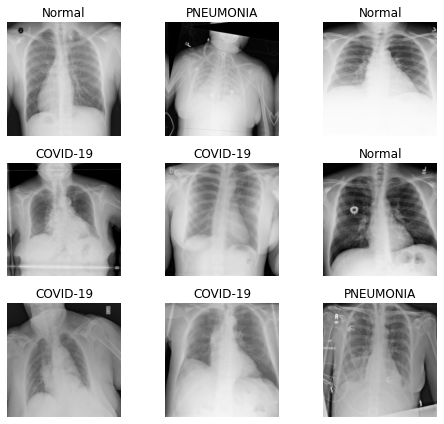

In [4]:
data.show_batch(rows=3, figsize=(7,6),recompute_scale_factor=True)

<a id="9"></a>
<font color="blue" size=+2.5><b>Print Classes present in the data</b></font>
<br/>

In [5]:
print(data.classes)
print("Train:",len(data.train_ds))
print("Val:",len(data.valid_ds))
print("Test:",len(data.test_ds))
data.c

['COVID-19', 'Normal', 'PNEUMONIA']
Train: 21715
Val: 4173
Test: 6788


3

In [6]:
data

ImageDataBunch;

Train: LabelList (21715 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
COVID-19,COVID-19,COVID-19,COVID-19,COVID-19
Path: ..\Datasets\CXR_30k;

Valid: LabelList (4173 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
COVID-19,COVID-19,COVID-19,COVID-19,COVID-19
Path: ..\Datasets\CXR_30k;

Test: LabelList (6788 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: ..\Datasets\CXR_30k

<a id="10"></a>
<font color="blue" size=+2.5><b>4.1 Create Model</b></font>
<br/>

In [7]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy,error_rate], model_dir = Path('../Model'),path = Path("."))

<a id="11"></a>
<font color="blue" size=+2.5><b>4.2 Finding LR</b></font>
<br/>

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


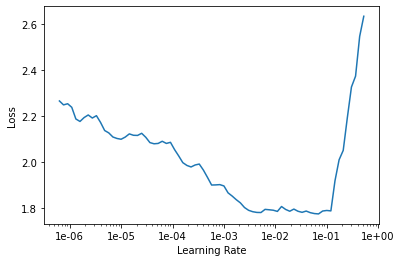

In [8]:
learn.lr_find()
learn.recorder.plot(suggestions=True)

<a id="12"></a>
<font color="blue" size=+2.5><b>4.3 Train Model</b></font>
<br/>

In [9]:
lr1 = 1e-3
lr2 = 1e-1
learn.fit_one_cycle(4,slice(lr1,lr2))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.237504,1.460934,0.710520,0.289480,02:53
1,0.714058,1.006219,0.838965,0.161035,02:10
2,0.401358,0.268872,0.899832,0.100168,02:11
3,0.292200,0.199057,0.924754,0.075246,02:12


In [10]:
# lr1 = 1e-3
lr = 1e-1
learn.fit_one_cycle(20,slice(lr))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.297427,0.715713,0.924754,0.075246,02:12
1,0.353389,0.221399,0.922118,0.077882,02:12
2,0.541901,0.547268,0.848071,0.151929,02:13
3,0.696759,1.538403,0.534148,0.465852,02:12
4,1.083115,0.810463,0.805416,0.194584,02:10
5,0.794036,5.324512,0.724419,0.275581,02:08
6,1.079484,1.213679,0.810208,0.189792,02:12
7,1.202274,0.560950,0.864845,0.135155,02:12
8,0.636634,1.268858,0.845675,0.154325,02:12
9,0.810501,0.402064,0.873712,0.126288,02:12


<a id="13"></a>
<font color="blue" size=+2.5><b>4.4 Hyper Parameter Tuning</b></font>
<br/>

In [11]:
# #
# import gc
# gc.collect()
# torch.cuda.empty_cache()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.278320,0.657611,0.919243,0.080757,02:46
1,0.270441,0.225640,0.921160,0.078840,02:51
2,0.334843,0.243628,0.914450,0.085550,02:59
3,0.303238,0.247823,0.909418,0.090582,02:48
4,0.301206,0.247784,0.910137,0.089863,02:41
5,0.249853,0.196228,0.929068,0.070932,02:47
6,0.212560,0.196004,0.923317,0.076683,02:46
7,0.205057,0.171184,0.937934,0.062066,02:47
8,0.194130,0.166172,0.938414,0.061586,02:46
9,0.189591,0.167266,0.937934,0.062066,02:46


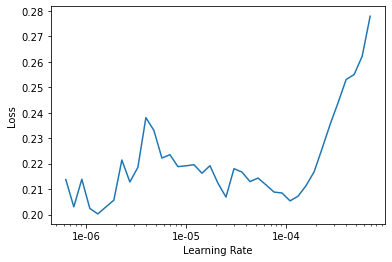

In [12]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()
learn.fit_one_cycle(10,slice(1e-4,1e-3))

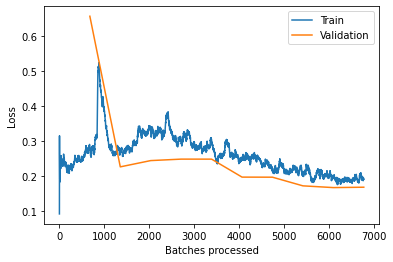

In [13]:
learn.recorder.plot_losses()

<a id="14"></a>
<font color="blue" size=+2.5><b>Interpret the results</b></font>
<br/>

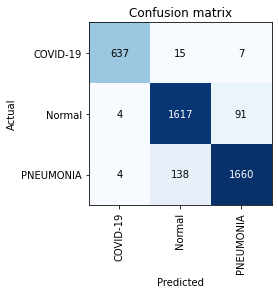

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

<a id="15"></a>
<font color="blue" size=+2.5><b>Validation of Model</b></font>
<br/>


[0.16726618, tensor(0.9379), tensor(0.0621)]


[5.5774455, tensor(0.3412), tensor(0.6588)]


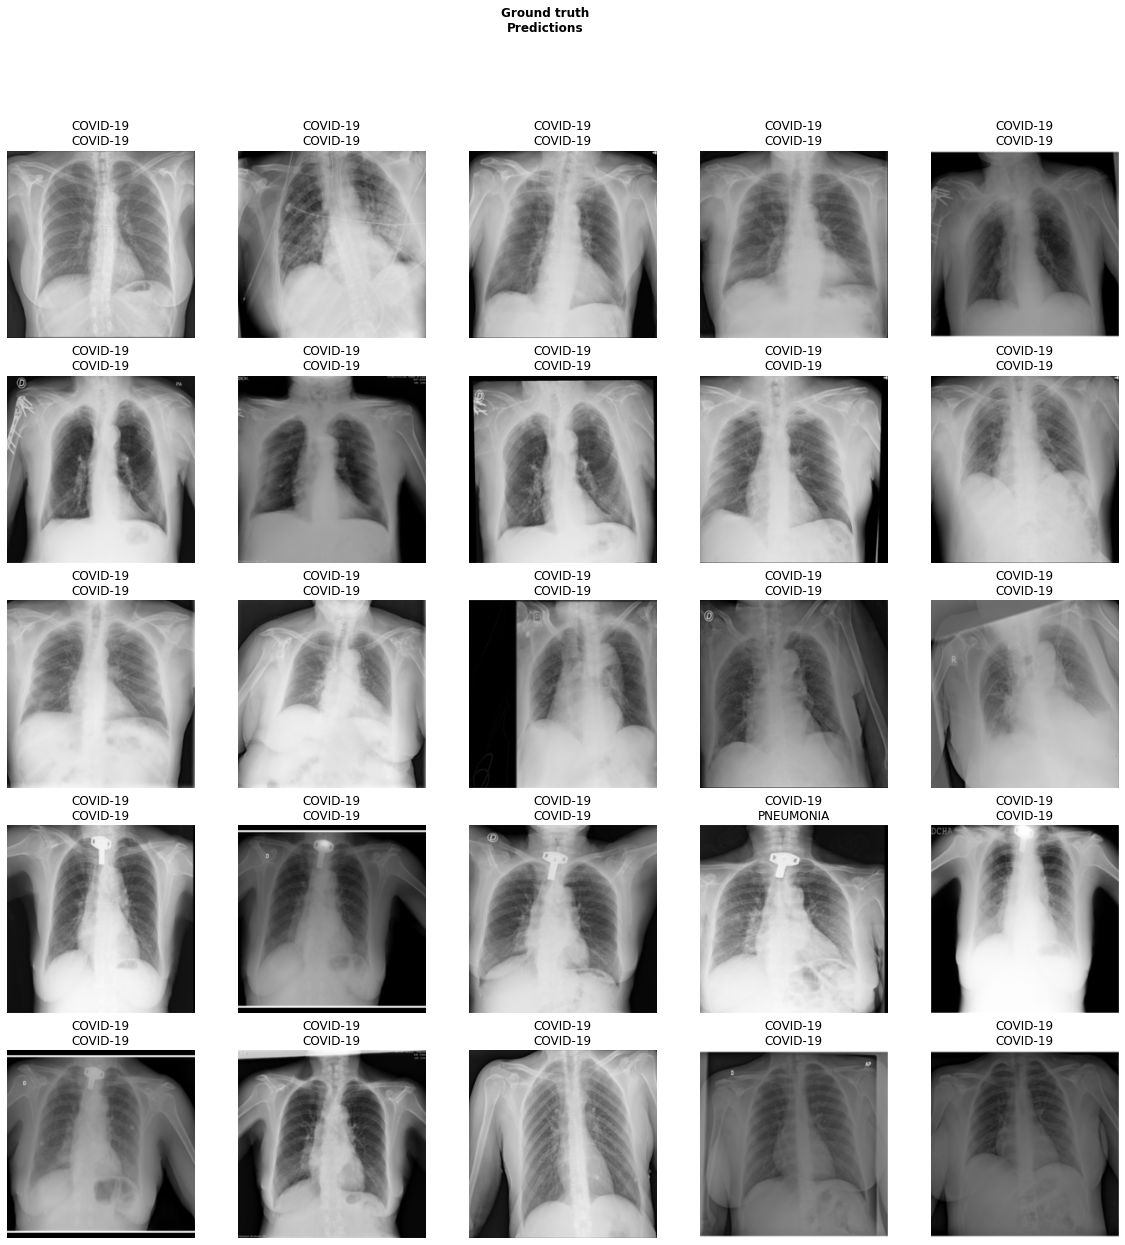

In [15]:
learn.show_results()
learn.validate()
print(learn.validate(learn.data.valid_dl))
print(learn.validate(learn.data.test_dl))

<a id="15"></a>
<font color="blue" size=+2.5><b>Confusion Matrix of Model</b></font>
<br/>

[[ 637   15    7]
 [   4 1617   91]
 [   4  138 1660]]


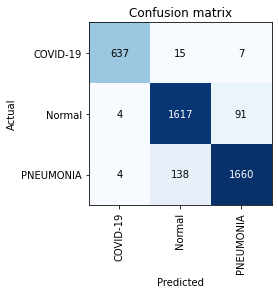

In [16]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
# print(losses)
interp.plot_confusion_matrix()
interp.top_losses()
conf = interp.confusion_matrix()
print(conf)

<a id="15"></a>
<font color="blue" size=+2.5><b>Prediction Using Trained Model</b></font>
<br/>

NORMAL TEST:
Normal 

COVID TEST:
COVID-19 

PNEUMONIA TEST:
PNEUMONIA 

TEST:
Normal 



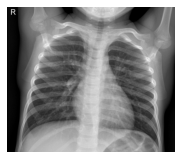

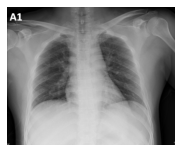

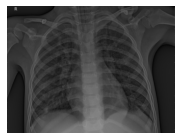

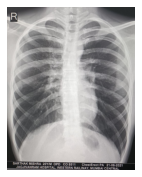

In [17]:
img_n = open_image('../Datasets/CXR_20k/test/NORMAL/IM-0063-0001.jpeg')
s =  open_image('../Sathak/sarthak.jpg')
img_c = open_image('../Datasets/CXR_20k/test/COVID/1-s2.0-S1684118220300682-main.pdf-002-a1.png')
img_p = open_image('../Datasets/CXR_20k/test/PNEUMONIA/person14_virus_44.jpeg')
print("NORMAL TEST:")
img_n.show()
print(learn.predict(img_n)[0],"\n")

print("COVID TEST:")
img_c.show()
print(learn.predict(img_c)[0],"\n")

print("PNEUMONIA TEST:")
img_p.show()
print(learn.predict(img_p)[0],"\n")

print("TEST:")
s.show()
print(learn.predict(s)[0],"\n")

<a id="15"></a>
<font color="blue" size=+2.5><b>Heat Map</b></font>
<br/>


In [18]:
m = learn.model.eval()

In [19]:
idx = 420

COVID-19


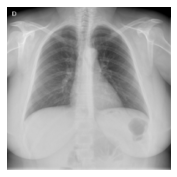

In [20]:
x,y = data.valid_ds[idx]
x.show()
x.shape
print(data.valid_ds.y[idx])

In [21]:
xb,_ = data.one_item(x) #takes all the settings from our previously created data object
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
xb.shape

torch.Size([1, 3, 224, 224])

In [22]:
from fastai.callbacks.hooks import *


In [23]:
def hooked_backward(lung=y):
    with hook_output(m[0]) as hook_a: #Get activations from the convolution layers
        with hook_output(m[0], grad = True) as hook_g: #Get gradient from convolution layers
            preds = m(xb) #DO foreward pass through model
            preds[0,int(lung)].backward()
    return hook_a, hook_g

In [24]:
hook_a, hook_g = hooked_backward()

In [25]:
acts = hook_a.stored[0].cpu()
acts.shape #Now we see our chanels over the 7x7 sections of the image

torch.Size([2048, 7, 7])

In [26]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [27]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax) #fastai function to show the image
    ax.imshow(hm, alpha = 0.6, extent = (0,224,224, 0), #extent expands the 11x11 image to 224,224
             interpolation = 'bilinear', cmap = 'magma')


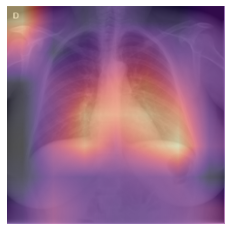

In [28]:
show_heatmap(avg_acts)

<a id="16"></a>
<font color="blue" size=+2.5><b>5.3 Save and Load Model</b></font>
<br/>


In [29]:
#Torch
learn.export(file = Path("../Model/Covid and Pnumonia.json"))
learn.model_dir = "../Model/"
learn.save("Covid and Pnumonia_pytorch",return_path=True)

WindowsPath('../Model/Covid and Pnumonia_pytorch.pth')